<h1>Chapter3: Generalized Linear Model</h1>
<h2>Poisson regression</h2>

<p>In this notebook, <br>**1.we implement poisson regression to describe how $\lambda$, the mean of the target variable(y<sub>i</sub>), changes depending on the value of the dependent variables<br> 2. we illustrate why and when generalized linear model can be preferable over linear model**</p>
<p>In the last notebook, we assumed that each y<sub>i</sub>(the number of seeds each plant has) comes from the same poisson distribution: $\Pr$(y|$\lambda) = \frac{\lambda^ye(-\lambda)}{y!}$</p>
<p>This time we assume that y<sub>i</sub> comes from a poisson distribution parameterized different $\lambda_i$ : $\Pr$(y<sub>i</sub>|$\lambda_i) = \frac{\lambda^y_ie(-\lambda)}{y_i!}$</p>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
ls ../data

data3a.csv  data_R.csv


In [3]:
df = pd.read_csv('../data/data3a.csv')

<h1>Description of dataset (fictional data)</h1>
<body>
    <p>Row: each row represents some kind of plant.</p>
    <p>Column</p>
    <ol>
        <li>y: a target variable( the number of seeds each plant has)</li>
        <li>x: the size of plants(this can be thought of as petal length (in cm) as an example)</li>
        <li>f: this takes on two values. C = control group (no treatment is given to this group), T = treatment group (
fertilization treatment is given to this group). Each group contains 50 plants respectively.</li>
    </ol>
</body>

<h2>What we are trying to analyze:</h2>
<h3>We want to see the effects of the size of plants and treatment on the number of seeds plants have</h3>

In [4]:
df.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [5]:
df.describe(include=['O'])

,f
count,100
unique,2
top,T
freq,50


In [6]:
df.describe(include='all')

,y,x,f
count,100.000000,100.000000,100
unique,NaN,NaN,2
top,NaN,NaN,T
freq,NaN,NaN,50
mean,7.830000,10.089100,NaN
std,2.624881,1.008049,NaN
min,2.000000,7.190000,NaN
25%,6.000000,9.427500,NaN
50%,8.000000,10.155000,NaN
75%,10.000000,10.685000,NaN


In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
y    100 non-null int64
x    100 non-null float64
f    100 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.4+ KB


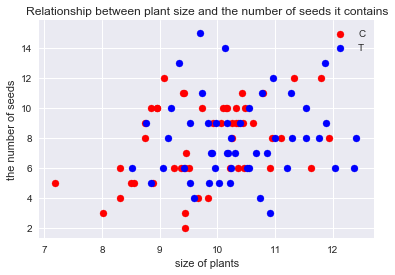

In [8]:
colors = ['red', 'blue']
factors = ['C', 'T']
for factor, color in zip(factors, colors):
    plt.scatter(df[df['f']==factor]['x'], df[df['f']==factor]['y'], c=color, label=factor)
    plt.legend()
plt.xlabel("size of plants")
plt.ylabel("the number of seeds")
plt.title("Relationship between plant size and the number of seeds it contains")
plt.show()

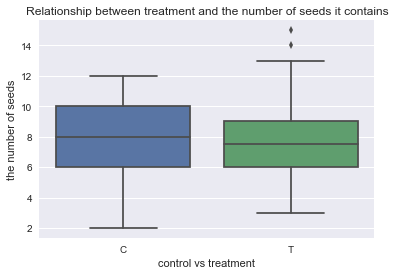

In [9]:
sns.boxplot(x="f", y="y", data=df)
plt.ylabel("the number of seeds")
plt.xlabel("control vs treatment")
plt.title("Relationship between treatment and the number of seeds it contains")
plt.show()

<h2>Linear predictor and log-link function</h2>
<body>
    <p>We assume that $\lambda_i$(mean of the number of seeds for each plant) is an output of a function of x<sub>i</sub></p>
    <p>$\lambda_i = exp(\beta_1 + \beta_2 X_i$)</p>
    <p>where $\beta_1$ is an intercept and $\beta_2$ is a slope</p>
    <p>Let's plot this function with differnet $\beta$'s below</p>
</body>

In [10]:
def expo_link(beta_1, beta_2):
    """show the exponential function for different beta"""
    x = np.arange(-5, 6)
    lambda_i = np.exp(beta_1 + beta_2 * x)
    plt.plot(x, lambda_i, label=r'$\beta_1={0}, \beta_2={1}$'.format(beta_1, beta_2))
    plt.ylim([0, 3.0])
    plt.xlabel('X')
    plt.ylabel(r'exp($\beta_1 + \beta_2*x_i$)')
    plt.vlines(0,ymin=0, ymax=3.0, linestyles='dashed')
    plt.title(r"Exponential function: exp($\beta_1 + \beta_2*x_i$)")
    plt.legend(loc='upper right')

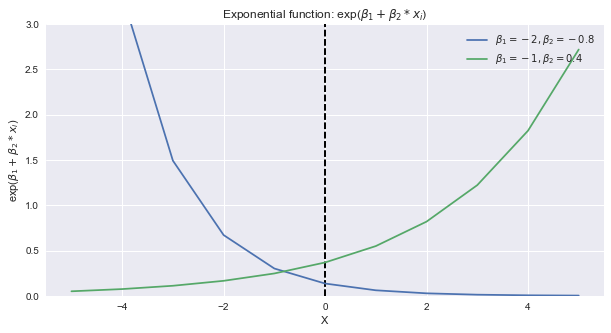

In [11]:
betas = [[-2, -0.8], [-1, 0.4]]
plt.figure(figsize=(10, 5))
for beta in betas:
    expo_link(*beta)

<p>If we take the log of the exponential function above, we can write the function as: </p>
<p>log $\lambda_i$ = $\beta_1 + \beta_2$*x<sub>i</sub></p>
<p>The right-hand side is called "linear predictor" since it is a linear combination of $\beta$'s</p>
<p>The left-hand side is called "link function". Link function takes the following form:<br> g($\mu_i$) (a function of mean of some parameter) = $\beta_1$ + $\beta_2$ * x<sub>i</sub> ... (linear predictor)</p>

<p>A function we use here is called "log link function" because we take the log of link function</p>

<head>
  <h2>Fitting Poisson regression</h2>
  <p>Fitting ultimately means determining the values of $\hat{\beta_1}, \hat{\beta_2}$(estimates of true intercept and slope, $\beta_1, \beta_2$), using maximum log-likelihood.</p>
  <p>Log-liklihood of Poisson regression is: </p>
  <p>logL($\beta_1, \beta_2$) = $\sum_i$*log*$\frac{\lambda_i^{y_i} exp(-\lambda_i)}{y_i!}$</p>
    <p>where $\lambda_i = exp(\beta_1 + \beta_2 x_i)$</p>
</head>

In [12]:
import statsmodels.api as sm

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
# specifiy that we use x as a feature and add a constant term
data_exog = sm.add_constant(df['x'])
# creat a  regression using Poisson distribution
poisson_model = sm.GLM(df['y'], data_exog, family=sm.families.Poisson())

In [14]:
# fit a regression
poisson_results = poisson_model.fit()

In [15]:
poisson_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Mon, 08 Oct 2018   Deviance:                       84.993
Time:                        23:12:59   Pearson chi2:                     83.8
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

<p>We can see estimates: $\hat{\beta_1} = 1.29, \hat{\beta_2} = 0.075$</p>

<p>Visualize the prediction line using a fitted model, $\lambda_i = exp(1.29 + 0.0757 x_i)$ </p>

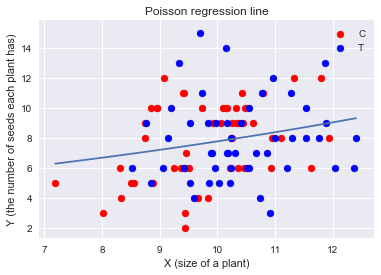

In [73]:
colors = ['red', 'blue']
factors = ['C', 'T']
for factor, color in zip(factors, colors):
    plt.scatter(df[df['f']==factor]['x'], df[df['f']==factor]['y'], c=color, label=factor)
    plt.legend()
xx = np.linspace(np.min(df['x']), np.max(df['x']),100)
plt.plot(xx, np.exp(1.2917 + 0.0757*xx))
plt.xlabel("X (size of a plant)")
plt.ylabel("Y (the number of seeds each plant has)")
plt.title("Poisson regression line")
plt.show()

<h3> Fitting Poisson regresion with treatment variable, f<sub>i</sub>, to see if 
there is any effect of fertilization on the number of seeds</h3>

<p>$\lambda_i$ = exp($\beta_1 + \beta_3 d_i$)</p>
<p>We create a dummy variable such that d<sub>i</sub> = 0 if f<sub>i</sub> = C else 1 (if f<sub>i</sub> = T)</p>
<p>That means, $\lambda_i$ = exp($\beta_1$) if f<sub>i</sub> = C , $\lambda_i$ = exp($\beta_1 + \beta_3 d_i$)
    if f<sub>i</sub> = T</p>

In [74]:
print(np.unique(df['f']))

['C' 'T']


In [75]:
# create a dummy varaible
f_dummy = df['f'].map({'C':0, 'T':1})

In [76]:
data_exog_f = sm.add_constant(f_dummy)
poisson_model_f = sm.GLM(df['y'], data_exog_f, family=sm.families.Poisson())

In [77]:
poisson_f_results = poisson_model_f.fit()

In [78]:
poisson_f_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Sun, 07 Oct 2018   Deviance:                       89.475
Time:                        02:59:10   Pearson chi2:                     87.1
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0516      0.051     40.463      0.000       1.952       2.151
f              0.0128      0.071      0.179      0.858      -0.127       0.153
==============================================================================
"""

<p>Fitting got worse since maximum log-likelihood estimate of Poisson regresion with f<sub>i</sub> went down to -237.63 from 
    -235.39 which is the estimate using x<sub>i</sub> as a feature</p>

<h2>Fit Poisson regression with 2 features, x<sub>i</sub>,f<sub>i</sub></h2>
<p>log $\lambda_i = \beta_1 + \beta_2 x_i+ \beta_3 d_i$</p>
<p>$\beta_1$ is an intercept, $\beta_2$ represents the effect of size of plants and $\beta_3$ represents the effect of treatment</p>

In [79]:
# turn panda series of X varaible to dataframe
df_tmp = df['x'].to_frame()
df_tmp['f'] = f_dummy
df_tmp['y'] = df['y']
df_tmp.head()

,x,f,y
0,8.31,0,6
1,9.44,0,6
2,9.50,0,6
3,9.07,0,12
4,10.16,0,10


In [80]:
import statsmodels.formula.api as smf
# create Poisson regression with two features
poisson_all = smf.glm(formula='y ~ x + f', data=df_tmp, family=sm.families.Poisson(sm.families.links.log))

In [81]:
poisson_all_results = poisson_all.fit()

In [82]:
poisson_all_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Sun, 07 Oct 2018   Deviance:                       84.808
Time:                        02:59:12   Pearson chi2:                     83.8
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.001       0.539       1.988
x              0.0801      0.037      2.162      0.031       0.007       0.153
f             -0.0320      0.074     -0.430      0.667      -0.178       0.114
==============================================================================
"""

<p>MLE went up to -235.29 from -235.39, mle of regression with only X variable</p>

<h3>Visuzlize prediction line of Poisson regresion with estimated $\beta$'s</h3>
<p>$\lambda_i = exp(1.26 + 0.0801 x_i -0.032 f_i)$ </p>

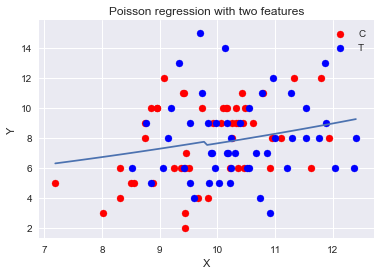

In [83]:
colors = ['red', 'blue']
factors = ['C', 'T']
for factor, color in zip(factors, colors):
    plt.scatter(df[df['f']==factor]['x'], df[df['f']==factor]['y'], c=color, label=factor)
    plt.legend()
xx = np.linspace(np.min(df['x']), np.max(df['x']),100)
ff = df_tmp['f'].values
plt.plot(xx, np.exp(1.2631 + 0.0801*xx-0.0320*ff))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Poisson regression with two features")
plt.show()

<h3>The effect of each feature when using log link function vs when using identity link function</h3>

<h4>1. Log link function</h4>
<p>$\lambda_i = exp(1.26 + 0.0801 x_i -0.032 d_i)$ can be decomposed into the effects of each variables. </p>
<p>$\lambda_i = exp(1.26) * exp(0.0801 x_i) * exp(-0.032 d_i)$ = (const) * (effect of size)  *(effect of treatment) </p>
<p> We can interpret that if size goes up by 1, the mean of the number of seeds goes up by 0.08, if treatment is given,  the mean of the number of seeds goes down by 0.032. <br>
**Important to note**:<br>
1. response value is non-negative because of exponentials in the right hand side equation<br>
2. Effect of each varaible grows exponentially as the value of each variable goes up</p>
<p>2. Identity link function</p>
<p>This is a function when no function (such as log function) is applied to link function</p>
<p> $\lambda_i = 1.26 + 0.0801 x_i -0.032 d_i$</p>
<p>**Important to note**:<br>
    response value is an ouput from a linear relationsip of each variable which is different when using log link function incorporating the multiplicative effect of variables
</p>

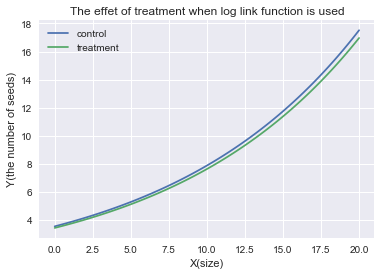

In [84]:
xx = np.linspace(0, 20, 100)
ff = [np.array([0] * 100), np.array([1] * 100)]
labels = ['control', 'treatment']
for i in range(2):
    plt.plot(xx, np.exp(1.2631 + 0.08*xx-0.0320*ff[i]), label=labels[i])
plt.xlabel("X(size)")
plt.ylabel("Y(the number of seeds)")
plt.legend()
plt.title("The effet of treatment when log link function is used")
plt.show()

In [85]:
poisson_idt = smf.glm(formula='y ~ x + f', data=df_tmp, family=sm.families.Poisson(sm.families.links.identity))

/Users/kentasuzuki/anaconda3/lib/python3.5/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


In [86]:
poisson_idt_results = poisson_idt.fit()

In [87]:
poisson_idt_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:               identity   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -235.16
Date:                Sun, 07 Oct 2018   Deviance:                       84.538
Time:                        02:59:16   Pearson chi2:                     83.6
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2671      2.843      0.446      0.656      -4.306       6.840
x              0.6606      0.290      2.281      0.023       0.093       1.228
f             -0.2048      0.582     -0.352      0.725      -1.346       0.936
==============================================================================
"""

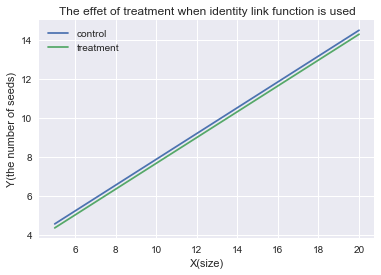

In [88]:
xx = np.linspace(5, 20, 100)
ff = [np.array([0] * 100), np.array([1] * 100)]
labels = ['control', 'treatment']
for i in range(2):
    plt.plot(xx, 1.2671 + 0.6606*xx-0.2048*ff[i], label=labels[i])
plt.title("The effet of treatment when identity link function is used")
plt.xlabel("X(size)")
plt.ylabel("Y(the number of seeds)")
plt.legend()
plt.show()

<h2>Generalized Linear Model V.S Linear Model</h2>
<p>Linear Model is a subset of Generalized Linear Model</p>
<p>Linear Model assumes that each sample is drawn from a Gaussian distribution with the same variance regardless of the values of the features a sample has</p>
<p>That is, Linear Model can be written as follows if it uses one feature, X, and tries to estimate Y:<br>
    $y_i = \mu_i = \beta_1 + \beta_2 x_i$</p>
<p>The assumption of Linear Model is too simple to capture the relationship between features and response value in reality. Sometimes response value we want to predict takes on only non-negative values, or each sample may be drawn from different variance.</p>
<p>Poisson regression is an appropriate on this dataset since y takes on non-negative integer value, and variance increases as the means of y increases</p>

<h2>Visualize the differnece between GLM and LM</h2>

In [95]:
def create_samples():
    """create samples for illustrating the difference between glm and lm"""
    values = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 3, 5, 6, 5, 6, 3]
    xx = np.linspace(0, 2, len(values))
    d_tmp = {'x': xx, 'y': values}
    df_tmp = pd.DataFrame(data=d)
    return df_tmp

In [96]:
def fit_glm(df):
    data_exog = sm.add_constant(df['x'])
    # creat a  regression using Poisson distribution
    poisson_model = sm.GLM(df['y'], data_exog, family=sm.families.Poisson())
    # fit a regression
    poisson_results = poisson_model.fit()
    intercept, slope = poisson_results.params[0], poisson_results.params[1]
    return intercept, slope

In [107]:
def plot_prediction(model):
    df = create_samples()
    if model == 'lm':
        ax = sns.regplot(x="x", y="y", data=df)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("linear regression")
        plt.show()
    else:
        print(df['x'].max(), np.max(df['x']))
        intercept, slope = fit_glm(df)
        xx = np.linspace(np.min(df['x']), np.max(df['x']))
        plt.scatter(df['x'], df['y'])
        plt.plot(xx, np.exp(intercept + slope*xx))
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("Poisson regression line")
        plt.show()

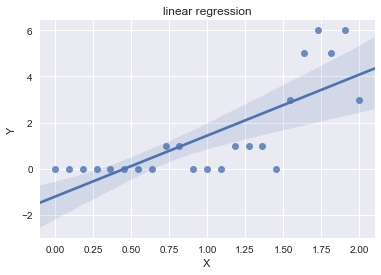

2.0 2.0


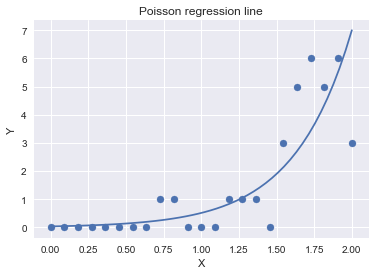

In [108]:
for model in ['lm', 'glm']:
    plot_prediction(model)

<p>Linear Model predicted negative values for X less than 0.5 even though X<sub>i</sub> takes on only non-negative values.It also failed to capture the increasing variance of data points at each X<sub>i</sub></p>